In [1]:
!pip install opendatasets


In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import torchvision.transforms as transforms
# from torchvision.datasets import Imageforlder
import torchvision.datasets as datasets
from torch.utils.data import  random_split, DataLoader
import random
from skimage import io
import matplotlib.pyplot as plt
# para opendataset
import opendatasets as od
from fastai.vision.all import *
import numpy as np
import torch
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"


# ***IMPLEMENTAMOS EL DATASET***

In [3]:
# Descargamos el dataset
dataset_link = "https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification"
od.download(dataset_link)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: carlososmar
Your Kaggle Key: ··········


100%|██████████| 82.0M/82.0M [00:03<00:00, 25.8MB/s]


In [4]:

dataset_dir = "/content/garbage-classification/Garbage classification/Garbage classification"

# Transformaciones al dataset
# transform = transforms.Compose([
#     # reafirmamos las dimenciones
#     transforms.Resize((60, 60)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean = (0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
# ])


transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((200,200)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: (x * 2) - 1)
])


# Dataset procesado de imagenes almacenadas en folders que lleva por nombre su respectivo label

dataset = datasets.ImageFolder(root= dataset_dir, transform = transform)

classes= ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']



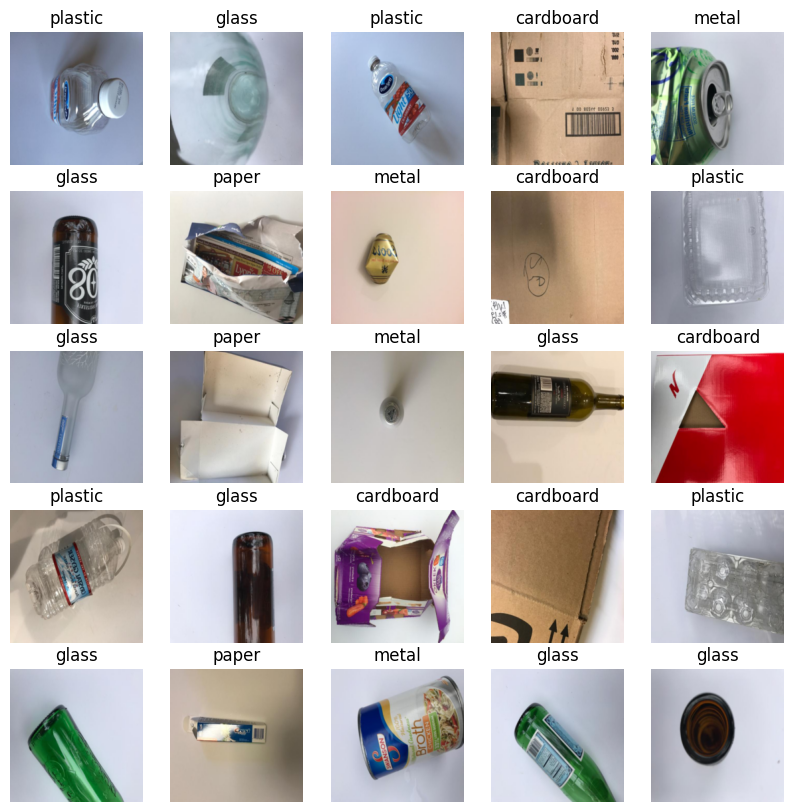

In [5]:
fig, axs = plt.subplots(5,5, figsize=(10,10))
for _ax in axs:
    for ax in _ax:
        ix = random.randint(0, len(dataset)-1)
        img, lab = dataset[ix]
        ax.imshow(((img+1)/2).permute(1,2,0))
        ax.axis('off')
        ax.set_title(classes[lab])
plt.show()

In [6]:
# número baches
batch_size= 64


dataloader_ = DataLoader(dataset, batch_size, shuffle= True, pin_memory = True)
classes = dataset.classes
print(classes)



# Calcula el tamaño del conjunto de prueba en función de la proporción
test_size = int(0.2 * len(dataloader_.dataset))

# Calcula el tamaño del conjunto de entrenamiento
train_size = len(dataloader_.dataset) - test_size

# Divide el conjunto de datos en entrenamiento y prueba
train_dataset, test_dataset = random_split(dataloader_.dataset, [train_size, test_size])

# Crea DataLoaders para Test y Train
batch_size = 64
dataloader = {
    'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True),
    'test': DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
}




['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [7]:
class_to_idx = dataset.class_to_idx
print(class_to_idx)

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


In [8]:

# regNet = models.efficientnet_v2_s(weights= True)
# regNet = models.efficientnet_v2_m(weights= True)
regNet = models.efficientnet_v2_l(weights= True)

regNet

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_L_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_L_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth
100%|██████████| 455M/455M [00:04<00:00, 114MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [9]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader




class ModelCustom(torch.nn.Module):
  def __init__(self, n_outputs=5, pretrained=False, freeze=False):
    super().__init__()
    # descargamos regnet
    # regNet = models.efficientnet_v2_s(weights= pretrained)
    # regNet = models.efficientnet_v2_m(weights= pretrained)
    regNet = models.efficientnet_v2_l(weights= pretrained)
    # nos quedamos con todas las capas menos la última
    self.regNet = torch.nn.Sequential(*list(regNet.children())[:-1])
    if freeze:
      for param in self.regNet.parameters():
        param.requires_grad=False
    # añadimos una nueva capa lineal para llevar a cabo la clasificación
    self.fc = torch.nn.Linear(1280, 6)

  def forward(self, x):
    x = self.regNet(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

  def unfreeze(self):
    for param in self.regNet.parameters():
        param.requires_grad=True



In [10]:
from tqdm import tqdm
import numpy as np

def fit(model, dataloader, epochs=16, lr_resnet=1e-4, lr_fc=1e-3):
    model.to(device)
    # momentum_value = 0.9
    # optimizer = optimizer = torch.optim.Adam([{'params': model.regNet.parameters(), 'lr': lr_resnet},{'params': model.fc.parameters(), 'lr': lr_fc}])
    optimizer = optimizer = torch.optim.AdamW([{'params': model.regNet.parameters(), 'lr': lr_resnet},{'params': model.fc.parameters(), 'lr': lr_fc}])
    # optimizer = optimizer = torch.optim.SGD([{'params': model.regNet.parameters(), 'lr': lr_resnet},{'params': model.fc.parameters(), 'lr': lr_fc}])
    # optimizer = optimizer = torch.optim.SGD([{'params': model.regNet.parameters(), 'lr': lr_resnet},{'params': model.fc.parameters(), 'lr': lr_fc}],  momentum=momentum_value)


    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

In [11]:
# model_c = ModelCustom()
# fit(model_c, dataloader)

In [12]:
# Transfer Learnign
model_c = ModelCustom(pretrained=True, freeze=True)
fit(model_c, dataloader, lr_resnet=1e-4, lr_fc=1e-3 )

val_loss 0.89352 val_acc 0.74931: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


Epoch 1/16 loss 1.21057 val_loss 0.89352 acc 0.58162 val_acc 0.74931


val_loss 0.66121 val_acc 0.79643: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


Epoch 2/16 loss 0.69110 val_loss 0.66121 acc 0.80266 val_acc 0.79643


val_loss 0.58762 val_acc 0.81034: 100%|██████████| 8/8 [00:06<00:00,  1.18it/s]


Epoch 3/16 loss 0.55398 val_loss 0.58762 acc 0.83912 val_acc 0.81034


val_loss 0.52094 val_acc 0.82768: 100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Epoch 4/16 loss 0.46919 val_loss 0.52094 acc 0.86809 val_acc 0.82768


val_loss 0.50366 val_acc 0.83792: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


Epoch 5/16 loss 0.40775 val_loss 0.50366 acc 0.88212 val_acc 0.83792


val_loss 0.46749 val_acc 0.84207: 100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


Epoch 6/16 loss 0.38072 val_loss 0.46749 acc 0.89173 val_acc 0.84207


val_loss 0.46782 val_acc 0.82792: 100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Epoch 7/16 loss 0.34589 val_loss 0.46782 acc 0.89890 val_acc 0.82792


val_loss 0.45609 val_acc 0.83011: 100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


Epoch 8/16 loss 0.31588 val_loss 0.45609 acc 0.90915 val_acc 0.83011


val_loss 0.43873 val_acc 0.84135: 100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


Epoch 9/16 loss 0.31234 val_loss 0.43873 acc 0.91062 val_acc 0.84135


val_loss 0.43033 val_acc 0.84964: 100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Epoch 10/16 loss 0.28752 val_loss 0.43033 acc 0.91324 val_acc 0.84964


val_loss 0.41505 val_acc 0.86160: 100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


Epoch 11/16 loss 0.28041 val_loss 0.41505 acc 0.92023 val_acc 0.86160


val_loss 0.41113 val_acc 0.84964: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


Epoch 12/16 loss 0.27448 val_loss 0.41113 acc 0.91679 val_acc 0.84964


val_loss 0.40065 val_acc 0.84817: 100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


Epoch 13/16 loss 0.25436 val_loss 0.40065 acc 0.92432 val_acc 0.84817


val_loss 0.39691 val_acc 0.86356: 100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


Epoch 14/16 loss 0.25453 val_loss 0.39691 acc 0.92167 val_acc 0.86356


val_loss 0.40322 val_acc 0.85208: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


Epoch 15/16 loss 0.23414 val_loss 0.40322 acc 0.93293 val_acc 0.85208


val_loss 0.40160 val_acc 0.85818: 100%|██████████| 8/8 [00:06<00:00,  1.23it/s]

Epoch 16/16 loss 0.23135 val_loss 0.40160 acc 0.93030 val_acc 0.85818


In [14]:
# fine tuning
model_c = ModelCustom(pretrained=True, freeze=False)
fit(model_c, dataloader, lr_resnet=1e-4, lr_fc=1e-3)

OutOfMemoryError: ignored

In [ ]:
model_o = ModelCustom(pretrained=True, freeze=True)
fit(model_o, dataloader, lr_resnet=1e-4, lr_fc=1e-3)
model_o.unfreeze()
fit(model_o, dataloader, lr_resnet=1e-4, lr_fc=1e-3)

In [ ]:
import matplotlib.pyplot as plt

def visualize_predictions(model, dataloader, device):
    # model.to(device)  # Mueve el modelo al dispositivo correcto
    model.eval()  # Asegúrate de que el modelo esté en modo de evaluación
    with torch.no_grad():
        for batch in dataloader:
            X, y = batch
            X, y = X.to(device), y.to(device)  # Mueve los datos al dispositivo
            y_hat = model(X)

            for i in range(len(y)):
                sample_image = X[i].cpu().numpy()  # Convierte la imagen a numpy (asegúrate de moverla a la CPU si es necesario)
                sample_label = y[i].item()  # Obtiene la etiqueta original como un valor escalar
                predicted_label = torch.argmax(y_hat[i]).item()  # Obtiene la etiqueta predicha
                plt.imshow(np.transpose(sample_image, (1, 2, 0)))  # Cambia las dimensiones para ser (altura, ancho, canales)
                plt.title(f"Original Label: {sample_label}, Predicted Label: {predicted_label}")
                plt.show()


# Llama a la función visualize_predictions después de entrenar tu modelo
# regNet = models.regnet_x_400mf(weights=None)
# fit(regNet, dataloader)
visualize_predictions(model_c, dataloader['test'],device)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, dataloader, device):
    # model.to(device)  # Mueve el modelo al dispositivo correcto
    model.eval()  # Asegúrate de que el modelo esté en modo de evaluación
    num_rows, num_cols = 5, 5  # Número de filas y columnas en la cuadrícula
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

    dataloader_iter = iter(dataloader)  # Crea un iterador para el dataloader

    with torch.no_grad():
        for row in range(num_rows):
            for col in range(num_cols):
                try:
                    batch = next(dataloader_iter)  # Obtén el próximo lote
                except StopIteration:
                    break

                X, y = batch
                X, y = X.to(device), y.to(device)  # Mueve los datos al dispositivo
                y_hat = model(X)

                for i in range(len(y)):
                    sample_image = X[i].cpu().numpy()  # Convierte la imagen a numpy (asegúrate de moverla a la CPU si es necesario)
                    # Normaliza los valores de píxeles al rango [0, 1]
                    sample_image = (sample_image - sample_image.min()) / (sample_image.max() - sample_image.min())
                    sample_label = y[i].item()  # Obtiene la etiqueta original como un valor escalar
                    predicted_label = torch.argmax(y_hat[i]).item()  # Obtiene la etiqueta predicha
                    axes[row, col].imshow(sample_image.transpose(1, 2, 0))  # Cambia las dimensiones para ser (altura, ancho, canales)
                    axes[row, col].set_title(f" {sample_label}/ {predicted_label}")
                    axes[row, col].axis('off')  # Desactiva los ejes

    plt.tight_layout()
    plt.show()

visualize_predictions(model_c, dataloader['test'], device)